## Table of contents <a id="contents"></a>

1. [Data Preparation](#preparation)
   - 4.1 [Feature Extraction](#extraction)
   - 4.2 [Initial Data Cleaning](#cleaning)
   - 4.3 [Feature Selection](#selection)
       - 4.3.1 [Random Forest](#rf_selection)
       - 4.3.2 [Lasso Selection](#lasso_selection)
       - 4.3.3 [PCA Selection](#pca_selection)
8. [References](#references)

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve
from pyswarm import pso

## Data Preparation <a name="preparation"></a>
### Feature Extraction <a id="extraction"></a>
[go back to the top](#contents)

A significant obstacle in analyzing the LIDC dataset is the absence of unique identifiers for the nodules. Multiple radiologists may annotate the same nodule, but there are no clear markers indicating when different annotations refer to the same physical nodule, complicating the determination of whether they describe the same nodule. 

Using clustering, as mentioned previously, can lead to issues such as having nodule annotations that exceed 4 separate entries, which is impossible and indicates that the clustering function is not working correctly. Clustering based on coordinates introduces arbitrary decisions, such as setting thresholds for overlap, which can lead to errors and inaccuracies. 

By treating each annotation as an independent sample, we can capture the variability in feature quantification and malignancy ratings due to differences in radiologists' experience, training, and potential mislabeling. This approach enhances objectivity in the analysis by avoiding subjective clustering decisions. Furthermore, it simplifies modeling and reflects the natural variability in radiologists' interpretations, ultimately improving model robustness and eliminating the need to choose between mean, mode, or median for certain features.

**FALTA JUSTIFICAR COM O ARTIGO 8.**

Given the information provided above, we implemented a Python script titled `features_extraction.py` that addresses the issues surrounding the LIDC-IDRI dataset's structure. Specifically, this script tackles the absence of unique identifiers for nodules and ensures that each annotation is treated independently to capture variability in radiologist assessments. The script extracts **radiomic features** using PyRadiomics, **frequency-domain features** using a 3D Fourier Transform, and **semantic features** based on the radiologists' annotations from the LIDC dataset.

Key components of the script include:

1. **Radiomic Feature Extraction:**
   - We used the `PyRadiomics` library to compute detailed radiomic features for each annotated nodule, including **texture**, **shape**, and **intensity** characteristics. These features are crucial for understanding the structure and properties of the nodules.

2. **3D Fourier Transform:**
   - A 3D Fourier Transform is applied to the nodule images to derive features from the frequency domain. Specifically, we computed a normalized histogram of the magnitude spectrum to capture the nodule's frequency characteristics.

3. **Semantic Feature Extraction:**
   - The script extracts **semantic features** that were annotated by radiologists in the LIDC-IDRI dataset. These include attributes such as **subtlety**, **internal structure**, **calcification**, **sphericity**, **margin**, **lobulation**, **spiculation**, **texture**, **malignancy**, **diameter**, **surface area**, and **volume**. These features capture the subjective assessments made by radiologists regarding each nodule’s characteristics.

4. **Nodule Handling and Annotations:**
   - For each scan, we extract the nodule’s region using its bounding box. Both radiomic and semantic features (as described above) are included in the final feature set.
   - The absence of unique identifiers in the LIDC-IDRI dataset is addressed by assigning a unique Nodule_ID to each annotation, ensuring that each nodule is treated as an independent entity.

5. **Multithreaded Processing:**
   - To improve performance, we employ multithreading using Python’s ThreadPoolExecutor, enabling concurrent processing of multiple scans and nodules. A thread-safe locking mechanism ensures the correct assignment of unique Nodule_IDs.

6. **Final Output:**
   - The extracted features are saved to a pandas DataFrame and then exported as a CSV file (`radiomic_features_pylidc_and_fourier_per_annotation.csv`), which contains both radiomic, semantic, and 3D Fourier features for each nodule annotation.

**Note**:
Due to the heavy computational and memory demands of processing medical imaging data, we **recommend running this script locally** rather than directly in a Jupyter Notebook. Running the script locally allows for more efficient processing of large datasets and multi-threaded operations, ensuring better performance and stability.

In [ ]:
import pylidc as pl
import SimpleITK as sitk
import pandas as pd
from radiomics import featureextractor
import numpy as np
from concurrent.futures import ThreadPoolExecutor
from scipy.fftpack import fftn  # Import FFT 3D function
import threading  # For thread-safe operations

# Initialize the feature extractor
extractor = featureextractor.RadiomicsFeatureExtractor()

# Query the LIDC-IDRI dataset for scans with annotations
scans_with_annotations = pl.query(pl.Scan).filter(pl.Scan.annotations.any()).all()

# Lists to store the extracted features
features_list = []
nodule_id_counter = 1
nodule_id_lock = threading.Lock()  # Lock for thread-safe incrementing

# Function to compute 3D Fourier Transform and return relevant metrics
def calculate_fourier_3d(nodule_image):
    # Apply 3D Fourier Transform (FFT)
    fourier_transformed = fftn(nodule_image)

    # Extract magnitude spectrum (absolute values)
    magnitude_spectrum = np.abs(fourier_transformed)

    # Compute histogram with 10 bins
    hist, _ = np.histogram(magnitude_spectrum, bins=10)

    # Normalize histogram
    hist_normalized = hist / np.sum(hist)

    # Return the normalized histogram as features
    return {f'fourier_hist_bin_{i}': hist_normalized[i] for i in range(10)}

# Function to process a single scan and extract features
def process_scan(scan):
    global nodule_id_counter  # Keep track of nodule IDs across threads
    feature_data = []

    # Get the patient ID
    patient_id = scan.patient_id

    # Load the full scan volume
    scan_array = scan.to_volume()

    # Handle pixel spacing depending on its type
    if isinstance(scan.pixel_spacing, (list, tuple)):
        spacing = (scan.pixel_spacing[0], scan.pixel_spacing[1], scan.slice_thickness)
    else:
        # Assuming the spacing is isotropic, if pixel_spacing is a single float
        spacing = (scan.pixel_spacing, scan.pixel_spacing, scan.slice_thickness)

    # Convert the NumPy array to a SimpleITK image for radiomics processing
    scan_image = sitk.GetImageFromArray(scan_array)
    scan_image.SetSpacing(spacing)

    # Iterating through all annotations of the patient
    for ann in scan.annotations:
        # Get the bounding box for the annotation to reduce processing area
        bbox = ann.bbox()

        # Extract the nodule region from the scan array
        nodule_array = scan_array[bbox]

        # Get the mask for the annotation
        mask = ann.boolean_mask(pad=[(0, 0), (0, 0), (0, 0)])

        # Ensure the mask and nodule_array have the same shape
        if nodule_array.shape != mask.shape:
            # Resize mask to match nodule_array shape if necessary
            mask = mask[:nodule_array.shape[0], :nodule_array.shape[1], :nodule_array.shape[2]]

        # Convert the nodule array and mask to SimpleITK images
        nodule_image_sitk = sitk.GetImageFromArray(nodule_array)
        nodule_image_sitk.SetSpacing(spacing)

        mask_image = sitk.GetImageFromArray(mask.astype(np.uint8))
        mask_image.SetSpacing(spacing)

        # Extract radiomic features using PyRadiomics
        features = extractor.execute(nodule_image_sitk, mask_image, label=1)

        # Add the patient ID and a unique ID for the nodule
        features['Patient_ID'] = patient_id

        # Thread-safe increment of nodule_id_counter
        with nodule_id_lock:
            features['Nodule_ID'] = f'Nodule_{nodule_id_counter}'
            nodule_id_counter += 1

        # Include the annotation's semantic features directly
        features.update({
            'subtlety': ann.subtlety,
            'internalStructure': ann.internalStructure,
            'calcification': ann.calcification,
            'sphericity': ann.sphericity,
            'margin': ann.margin,
            'lobulation': ann.lobulation,
            'spiculation': ann.spiculation,
            'texture': ann.texture,
            'malignancy': ann.malignancy,
            'diameter': ann.diameter,
            'surface_area': ann.surface_area,
            'volume': ann.volume
        })

        # Calculate Fourier Transform 3D features
        fourier_features = calculate_fourier_3d(nodule_array)
        features.update(fourier_features)

        # Add the features to the feature data
        feature_data.append(features)

    return feature_data

# Multithreaded execution
with ThreadPoolExecutor(max_workers=8) as executor:
    results = executor.map(process_scan, scans_with_annotations)

# Collect results from all workers
for result in results:
    features_list.extend(result)

# Create a DataFrame to store the features
features_df = pd.DataFrame(features_list)

# Save the features to a CSV file
features_df.to_csv('radiomic_features_pylidc_and_fourier_per_annotation.csv', index=False)

### Initial Data Cleaning <a id="cleaning"></a>
[go back to the top](#contents)

Before proceeding with feature selection, we applied several data cleaning steps to the dataset to prioritize the most relevant features for modeling. The cleaning process includes:

- **Removing Diagnostic Columns**: We removed columns that contain basic diagnostic information about the images and masks, such as the mean pixel intensity and voxel counts. These columns serve as quality control indicators for the image processing pipeline but are often redundant and do not directly contribute to the prediction of malignancy. The following columns were removed: `diagnostics_Image-original_Mean`, `diagnostics_Image-original_Minimum`, `diagnostics_Image-original_Maximum`, `diagnostics_Mask-original_VoxelNum`, and `diagnostics_Mask-original_VolumeNum`.

- **Dropping Non-Numerical Columns**: All non-numeric columns were removed. Non-numeric data is unlikely to contribute meaningfully to the malignancy prediction task and can complicate the modeling process, so these columns were excluded.

- **Filtering Based on Malignancy**: Rows with a `malignancy` rating of 3, which represents ambiguous cases, were removed. This step ensures the data focuses on clear cases of benign and malignant nodules, reducing noise and making the classification task more straightforward.

- **Saving the Cleaned Dataset**: After applying the above steps, the cleaned dataset containing only numeric columns was saved as `all_features_cleaned.csv` for further analysis and feature selection.

The following code implements these data cleaning steps:

In [39]:
# Load the dataset
df = pd.read_csv('radiomic_features_pylidc_and_fourier_per_annotation.csv')

# Define the diagnostic columns to remove
columns_to_remove = [
    'diagnostics_Image-original_Mean',
    'diagnostics_Image-original_Minimum',
    'diagnostics_Image-original_Maximum',
    'diagnostics_Mask-original_VoxelNum',
    'diagnostics_Mask-original_VolumeNum'
]

# Drop the diagnostic columns
df = df.drop(columns=columns_to_remove)

# Identify non-numeric columns (object, category, etc.)
non_numeric_cols = df.select_dtypes(exclude=[float, int]).columns.tolist()

# Drop the identified non-numeric columns
df = df.drop(columns=non_numeric_cols)

# Remove rows where 'malignancy' == 3
df = df[df['malignancy'] != 3]

# Save the cleaned DataFrame with only numeric columns to a new CSV file
df.to_csv('all_features_cleaned.csv', index=False)


In [40]:
df = pd.read_csv('all_features_cleaned.csv')

num_cols = len(df.columns)
print(f'The cleaned CSV file has {num_cols} columns.')

print("\nColumn names:")
print(df.columns.tolist())

The cleaned CSV file has 129 columns.

Column names:
['original_shape_Elongation', 'original_shape_Flatness', 'original_shape_LeastAxisLength', 'original_shape_MajorAxisLength', 'original_shape_Maximum2DDiameterColumn', 'original_shape_Maximum2DDiameterRow', 'original_shape_Maximum2DDiameterSlice', 'original_shape_Maximum3DDiameter', 'original_shape_MeshVolume', 'original_shape_MinorAxisLength', 'original_shape_Sphericity', 'original_shape_SurfaceArea', 'original_shape_SurfaceVolumeRatio', 'original_shape_VoxelVolume', 'original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_Entropy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean', 'original_firstorder_Median', 'original_firstorder_Minimum', 'original_firstorder_Range', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_Ro

After performing the initial cleaning steps, the cleaned CSV file still contains 129 columns. While we have removed non-numerical and diagnostic columns, as well as filtered out ambiguous malignancy ratings, the dataset still includes a large number of features. 

Given the high dimensionality of the data, we will need to proceed with **feature selection** to reduce the number of features and focus on the most relevant variables for malignancy prediction. This step will help enhance model performance by minimizing noise and improving interpretability.


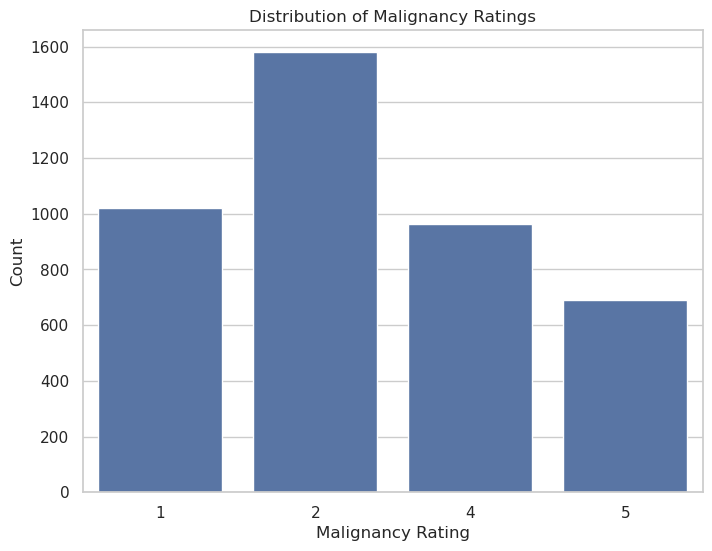

In [41]:
df = pd.read_csv('all_features_cleaned.csv')

sns.set(style='whitegrid')

# Create a bar plot for malignancy ratings
plt.figure(figsize=(8, 6))
sns.countplot(x='malignancy', data=df, order=[1, 2, 4, 5])
plt.title('Distribution of Malignancy Ratings')
plt.xlabel('Malignancy Rating')
plt.ylabel('Count')
plt.show()

Concerning the malignancy distribution, the bar plots show that:

- Approximately **61%** of the samples have been rated as malignant (ratings 4 and 5).
- Around **39%** of the samples are classified as benign (ratings 1 and 2).

Given this distribution, while there is a slight imbalance between malignant and benign cases, the ratio is not extreme. In this case, it may not be necessary to apply advanced imbalance-handling techniques, such as oversampling (e.g., SMOTE or ADASYN) or undersampling. The imbalance is relatively modest and can often be managed without the need for specific resampling strategies.


Diagnosis Category Counts:
diagnosis
benign       2600
malignant    1653
Name: count, dtype: int64


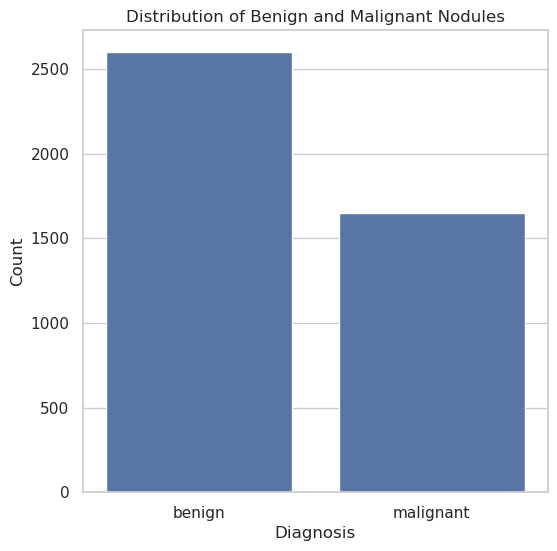

Percentage of Benign Cases: 61.13%
Percentage of Malignant Cases: 38.87%


In [42]:
# Define a mapping from malignancy ratings to diagnosis categories
diagnosis_mapping = {1: 'benign', 2: 'benign', 4: 'malignant', 5: 'malignant'}

# Create a new column 'diagnosis' based on the mapping
df['diagnosis'] = df['malignancy'].map(diagnosis_mapping)

# Get the counts of each diagnosis category
diagnosis_counts = df['diagnosis'].value_counts()
print("\nDiagnosis Category Counts:")
print(diagnosis_counts)

# Create a bar plot for diagnosis categories
plt.figure(figsize=(6, 6))
sns.countplot(x='diagnosis', data=df, order=['benign', 'malignant'])
plt.title('Distribution of Benign and Malignant Nodules')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.show()

# Calculate percentages
total_cases = len(df)
benign_count = diagnosis_counts['benign']
malignant_count = diagnosis_counts['malignant']

benign_percentage = (benign_count / total_cases) * 100
malignant_percentage = (malignant_count / total_cases) * 100

print(f"Percentage of Benign Cases: {benign_percentage:.2f}%")
print(f"Percentage of Malignant Cases: {malignant_percentage:.2f}%")

### Feature Selection <a id="selection"></a>
[go back to the top](#contents)

As mentioned in **Article 2**, the most commonly used algorithms for feature selection are:
- Random Forest: A tree-based algorithm that ranks features based on their importance in predicting the target variable.
- PCA (Principal Component Analysis): A dimensionality reduction technique that transforms features into a set of uncorrelated components while preserving as much variance as possible.
- LASSO (Least Absolute Shrinkage and Selection Operator): A regression method that performs both variable selection and regularization, helping to eliminate irrelevant features while improving the model's performance.

We will apply these three feature selection methods across multiple datasets before proceeding to classifier training. The datasets we are using are:
- PyLidc Features: This dataset contains semantic features extracted from the LIDC annotations. We will use this dataset without performing feature selection.
- Radiomic Features: This dataset includes radiomic features extracted using PyRadiomics and 3D Fourier features. We will test this dataset both with and without feature selection.
- Combined Dataset: This dataset merges the semantic features from PyLidc with the radiomic features. We will also test this combined dataset with and without feature selection.

The feature selection algorithms (Random Forest, PCA, and LASSO) will be used to reduce the dimensionality and focus on the most relevant features for each dataset. After performing feature selection, we will evaluate which method yields the best subset of features for classification.

In [43]:
df_combined = pd.read_csv('all_features_cleaned.csv')

# List of PyLidc semantic features
pylidc_features = [
    'subtlety', 'internalStructure', 'calcification', 'sphericity', 'margin', 
    'lobulation', 'spiculation', 'texture', 'diameter', 'surface_area', 'volume'
]

# Ensure 'malignancy' is retained in all datasets
target_column = ['malignancy']

# Separate PyLidc features (including 'malignancy')
df_pylidc = df_combined[pylidc_features + target_column]

# Separate Radiomic and Fourier features (including 'malignancy')
df_radiomic = df_combined.drop(columns=pylidc_features).copy()  

# Save the datasets without normalization
df_pylidc.to_csv('pylidc_features.csv', index=False)
df_radiomic.to_csv('radiomic_features.csv', index=False)

#### Random Forest <a id="rf_selection"></a>
[go back to the top](#contents)

In [55]:
df = pd.read_csv('all_features_cleaned.csv')

# Classifying the malignancy
df['malignancy'] = df['malignancy'].replace({1: 0, 2: 0, 4: 1, 5: 1})  # 0 = benign, 1 = malignant

# Separate Features and Target
X = df.drop('malignancy', axis=1)  # Features
y = df['malignancy']  # Target

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the Random Forest model
rf.fit(X_train, y_train)

# Make predictions and calculate accuracy before feature selection
y_pred = rf.predict(X_test)
initial_accuracy = accuracy_score(y_test, y_pred)
print(f"Initial accuracy: {initial_accuracy:.4f}")

Initial accuracy: 0.8707


In [45]:
df = pd.read_csv('all_features_cleaned.csv')

# Classifying the malignancy
df['malignancy'] = df['malignancy'].replace({1: 0, 2: 0, 4: 1, 5: 1})  # 0 = benign, 1 = malignant

# Separate Features and Target
X = df.drop('malignancy', axis=1)  # Features
y = df['malignancy']  # Target

# Train-Test Split (no scaling)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the Random Forest model
rf.fit(X_train, y_train)

# Make predictions and calculate accuracy before feature selection
y_pred = rf.predict(X_test)
initial_accuracy = accuracy_score(y_test, y_pred)
print(f"Initial accuracy: {initial_accuracy:.4f}")


Initial accuracy: 0.8707


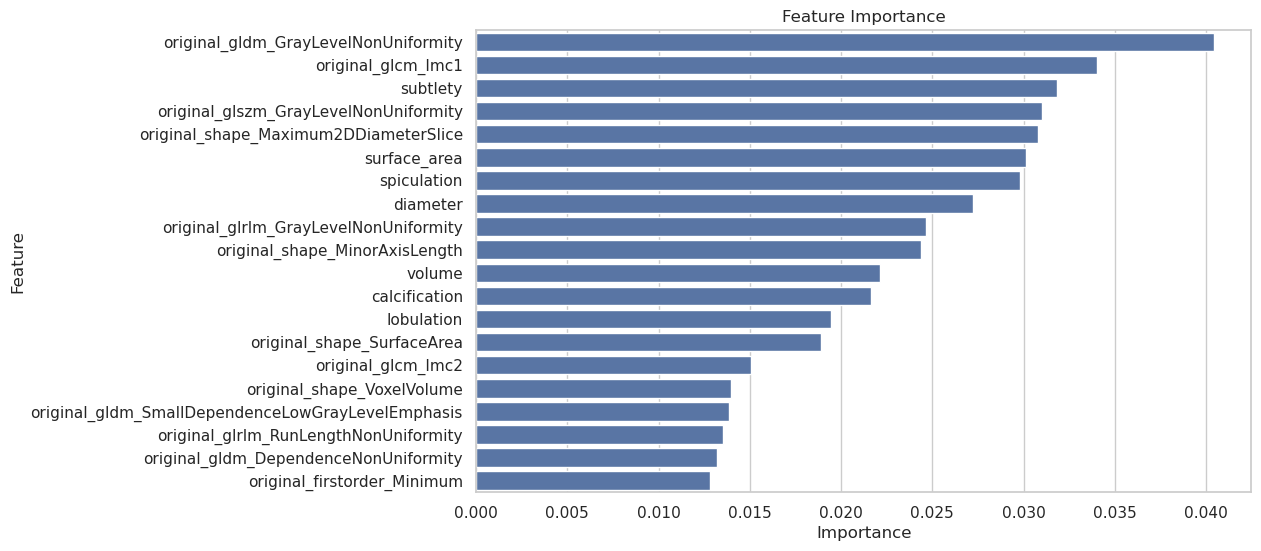

In [46]:
# Get feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df_small = feature_importance_df.head(20)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_small)
plt.title('Feature Importance')
plt.show()

Initial accuracy (before feature selection): 0.8719


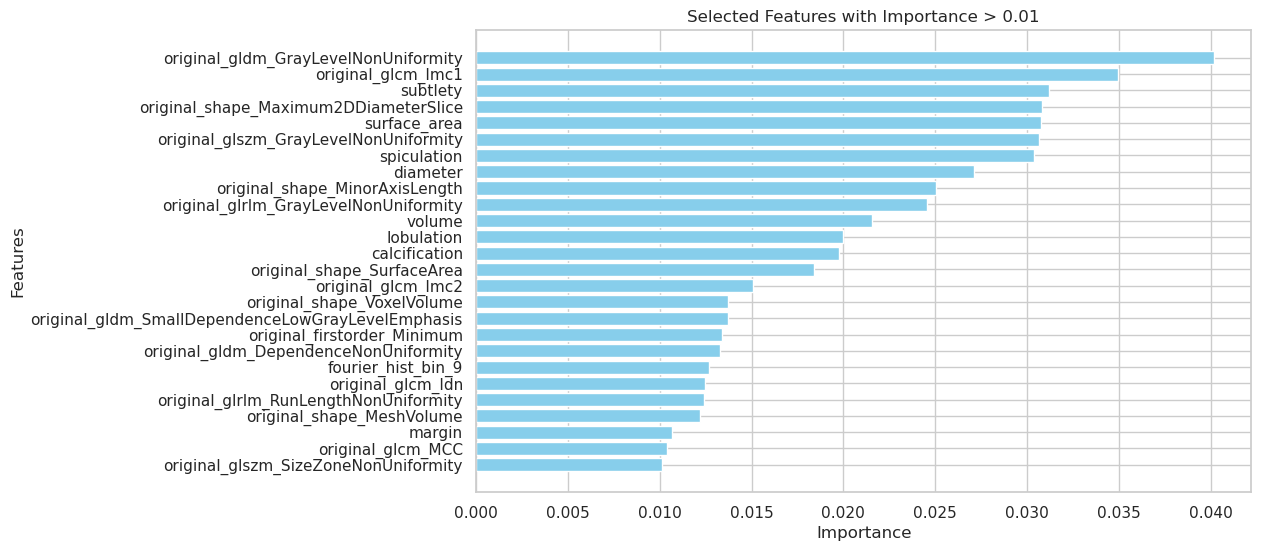

Accuracy after feature selection: 0.8801


In [47]:
df = pd.read_csv('all_features_cleaned.csv')

# Classifying the malignancy
df['malignancy'] = df['malignancy'].replace({1: 0, 2: 0, 4: 1, 5: 1})  # 0 = benign, 1 = malignant

# Separate Features and Target
X = df.drop('malignancy', axis=1)  # Features
y = df['malignancy']  # Target

# Normalize Features Between 0 and 1
scaler = MinMaxScaler()
X_normalized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make predictions and calculate accuracy before feature selection
y_pred = rf.predict(X_test)
initial_accuracy = accuracy_score(y_test, y_pred)
print(f"Initial accuracy (before feature selection): {initial_accuracy:.4f}")

# Get feature importances from the Random Forest model
feature_importances = rf.feature_importances_

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Threshold to select important features 
threshold = 0.01
selected_features = importance_df[importance_df['Importance'] > threshold]['Feature'].tolist()

# Plot the selected features and their importances
plt.figure(figsize=(10, 6))
important_features_df = importance_df[importance_df['Importance'] > threshold]
important_features_df = important_features_df.sort_values(by='Importance', ascending=False)
plt.barh(important_features_df['Feature'], important_features_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title(f'Selected Features with Importance > {threshold}')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.show()

# Reduce the dataset to the selected features
X_selected_train = X_train[selected_features]
X_selected_test = X_test[selected_features]

# Train a new Random Forest Classifier on the selected features
rf_selected = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selected.fit(X_selected_train, y_train)

# Make predictions and calculate accuracy after feature selection
y_pred_selected = rf_selected.predict(X_selected_test)
accuracy_selected = accuracy_score(y_test, y_pred_selected)
print(f"Accuracy after feature selection: {accuracy_selected:.4f}")


#### LASSO <a id="lasso_selection"></a>
[go back to the top](#contents)

Accuracy before LASSO feature selection (baseline): 0.8790
Selected feature names by LASSO: Index(['original_shape_Elongation', 'original_shape_Flatness',
       'original_shape_LeastAxisLength', 'original_shape_MajorAxisLength',
       'original_shape_Maximum2DDiameterRow',
       'original_shape_Maximum2DDiameterSlice',
       'original_shape_Maximum3DDiameter', 'original_shape_MinorAxisLength',
       'original_shape_Sphericity', 'original_shape_SurfaceArea',
       'original_shape_SurfaceVolumeRatio', 'original_shape_VoxelVolume',
       'original_firstorder_Energy', 'original_firstorder_Entropy',
       'original_firstorder_InterquartileRange',
       'original_firstorder_Kurtosis',
       'original_firstorder_MeanAbsoluteDeviation',
       'original_firstorder_Minimum', 'original_firstorder_RootMeanSquared',
       'original_firstorder_Skewness', 'original_firstorder_TotalEnergy',
       'original_firstorder_Uniformity', 'original_glcm_ClusterShade',
       'original_glcm_Cluster

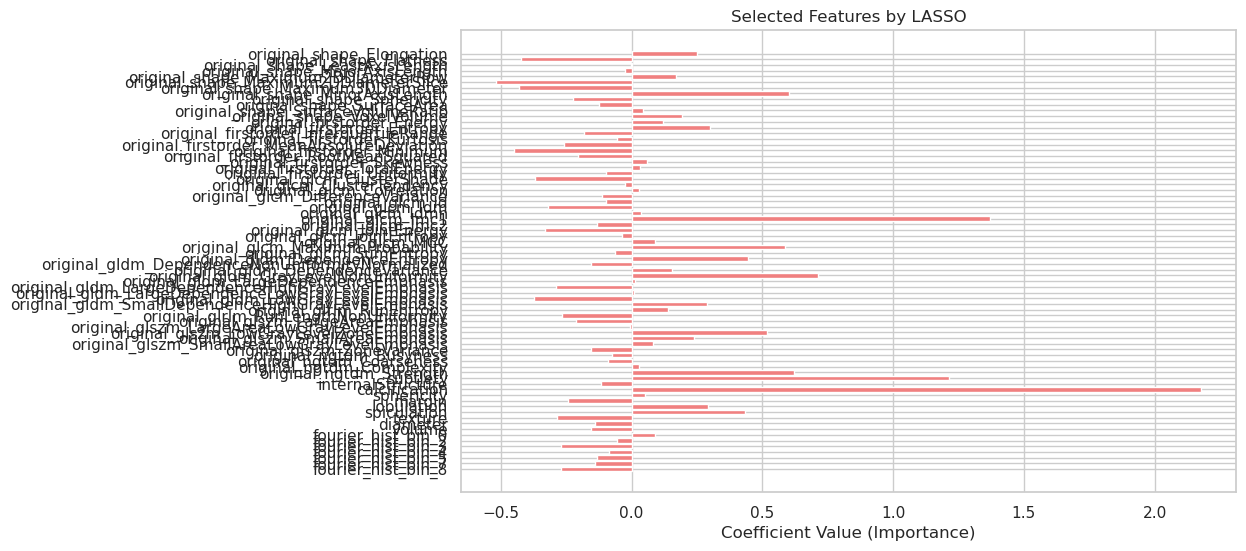

Accuracy after LASSO feature selection: 0.8778


In [52]:
df = pd.read_csv('all_features_cleaned.csv')

# Classifying the malignancy
df['malignancy'] = df['malignancy'].replace({1: 0, 2: 0, 4: 1, 5: 1})  # 0 = benign, 1 = malignant

# Separate Features and Target
X = df.drop('malignancy', axis=1)  # Features
y = df['malignancy']  # Target

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1. Train the Logistic Regression model (baseline) using all features
baseline_model = LogisticRegression(solver='liblinear', max_iter=1000)
baseline_model.fit(X_train_scaled, y_train)

# Make predictions and calculate accuracy before feature selection (baseline)
y_pred_baseline = baseline_model.predict(X_test_scaled)
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
print(f"Accuracy before LASSO feature selection (baseline): {baseline_accuracy:.4f}")

# 2. Train a Logistic Regression model with L1 (LASSO) regularization to perform feature selection
lasso = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, max_iter=1000)
lasso.fit(X_train_scaled, y_train)

# Get the coefficients of the LASSO model
coefficients = lasso.coef_

# Find the indices of the non-zero coefficients (these are the selected features)
non_zero_features = np.where(coefficients != 0)[1]

# Map the indices back to the original feature names
selected_feature_names = X.columns[non_zero_features]
print("Selected feature names by LASSO:", selected_feature_names)

# Plot the selected feature importances
plt.figure(figsize=(10, 6))
plt.barh(selected_feature_names, coefficients[0, non_zero_features], color='lightcoral')
plt.xlabel('Coefficient Value (Importance)')
plt.title('Selected Features by LASSO')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.show()

# 3. Use only the selected features to predict (after feature selection)
X_train_selected = X_train_scaled[:, non_zero_features]
X_test_selected = X_test_scaled[:, non_zero_features]

# Train a new Logistic Regression model on the selected features 
model = LogisticRegression(solver='liblinear', max_iter=1000)
model.fit(X_train_selected, y_train)

# Make predictions and calculate accuracy after feature selection
y_pred_selected = model.predict(X_test_selected)
accuracy_selected = accuracy_score(y_test, y_pred_selected)
print(f"Accuracy after LASSO feature selection: {accuracy_selected:.4f}")



#### PCA <a id="pca_selection"></a>
[go back to the top](#contents)

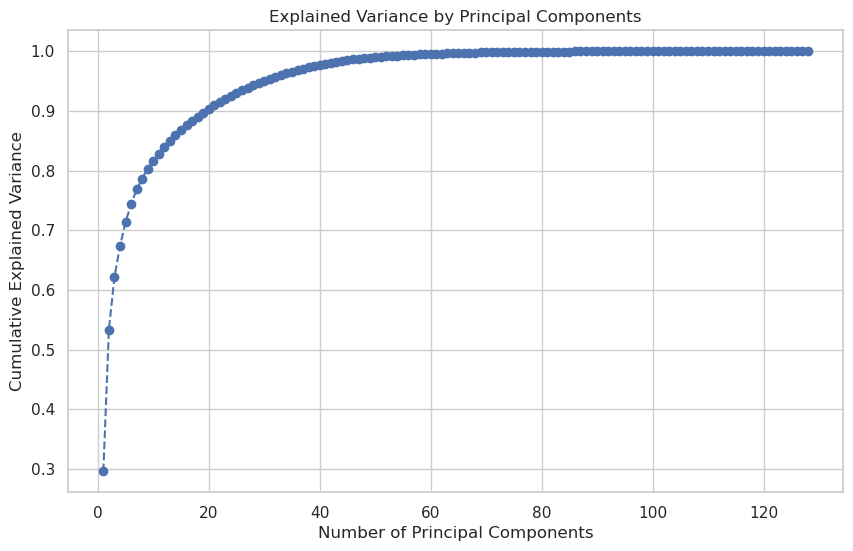

Number of components explaining 90% variance: 20
Most important features in each principal component: 0                                 original_glcm_Id
1                  original_gldm_DependenceEntropy
2                 original_glcm_MaximumProbability
3                  original_firstorder_TotalEnergy
4                          original_shape_Flatness
5                          original_shape_Flatness
6                      original_glszm_ZoneVariance
7     original_glszm_LargeAreaLowGrayLevelEmphasis
8                               original_glcm_Idmn
9                     original_firstorder_Kurtosis
10    original_glszm_LargeAreaLowGrayLevelEmphasis
11                         original_ngtdm_Contrast
12                                      sphericity
13                              fourier_hist_bin_6
14                      original_glcm_ClusterShade
15                              fourier_hist_bin_6
16                               internalStructure
17                             

In [53]:
df = pd.read_csv('all_features_cleaned.csv')

# Classifying the malignancy
df['malignancy'] = df['malignancy'].replace({1: 0, 2: 0, 4: 1, 5: 1})  # 0 = benign, 1 = malignant

# Separate Features and Target
X = df.drop('malignancy', axis=1)  # Features
y = df['malignancy']  # Target

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
pca = PCA()  # Keep all components initially
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot the explained variance to choose the number of components
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.grid(True)
plt.show()

# Choose the number of components that explain at least 90% of the variance
n_components = np.argmax(cumulative_variance >= 0.90) + 1
print(f"Number of components explaining 90% variance: {n_components}")

# Re-run PCA with the selected number of components
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Get the PCA components (most important features)
pca_components = pd.DataFrame(pca.components_, columns=X.columns)
most_important_features = pca_components.idxmax(axis=1)
print(f"Most important features in each principal component: {most_important_features}")